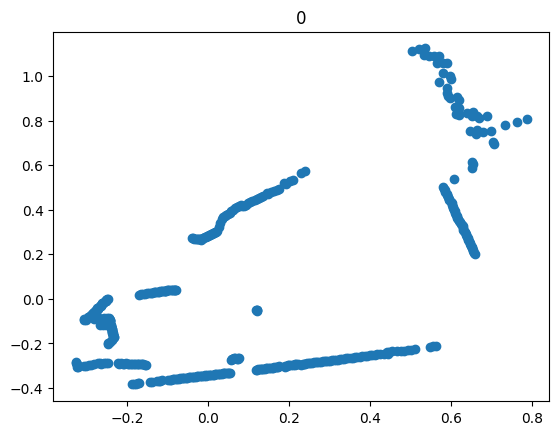

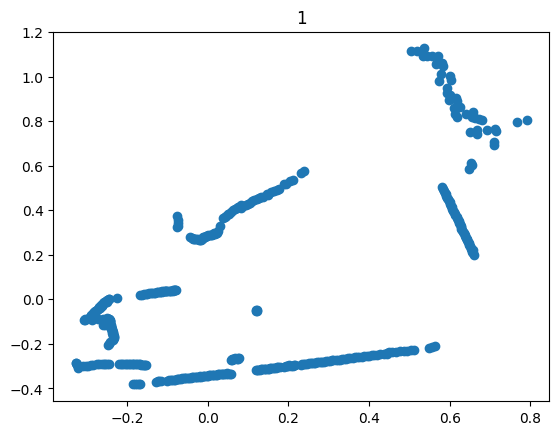

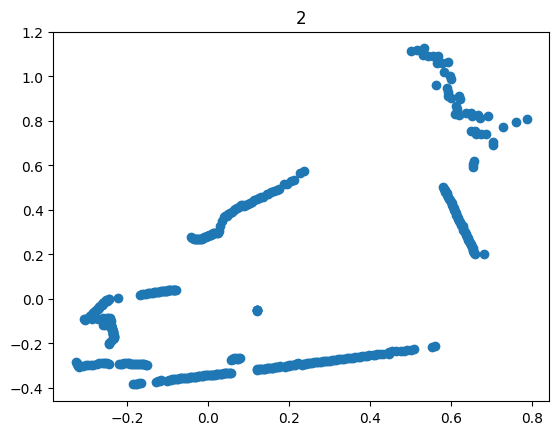

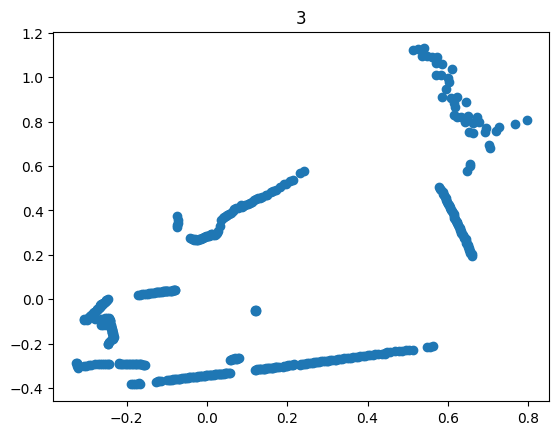

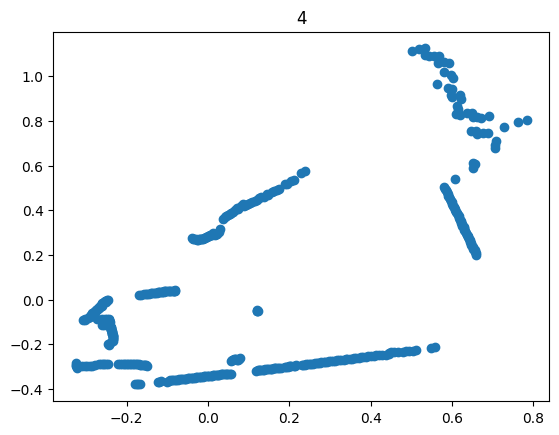

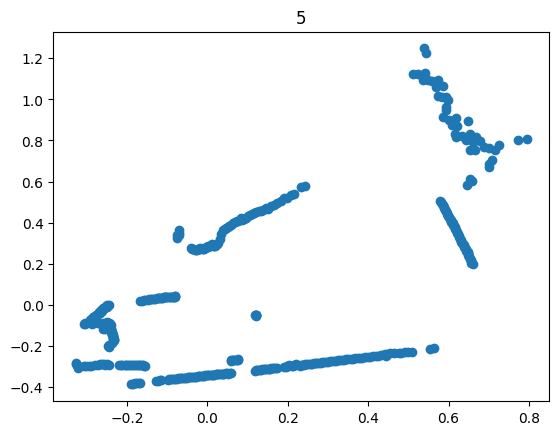

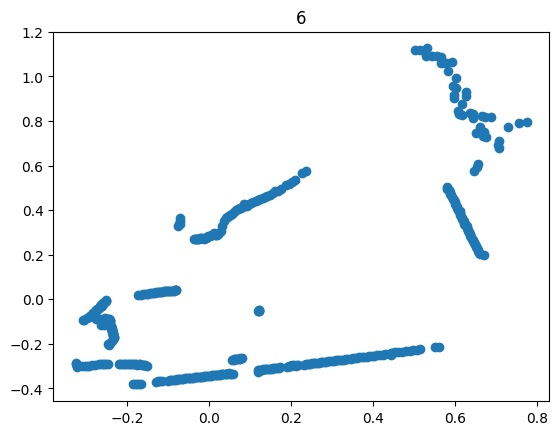

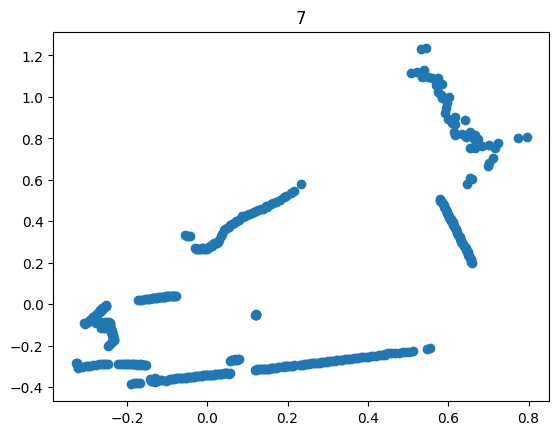

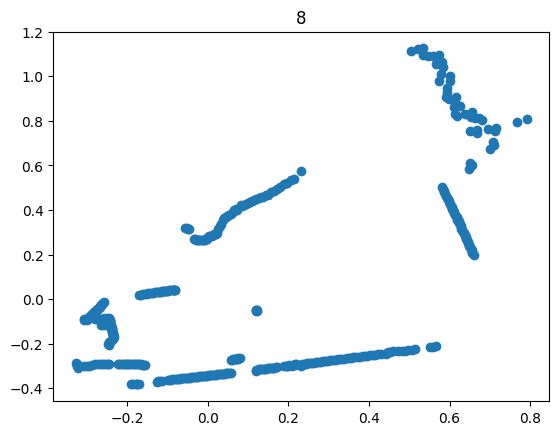

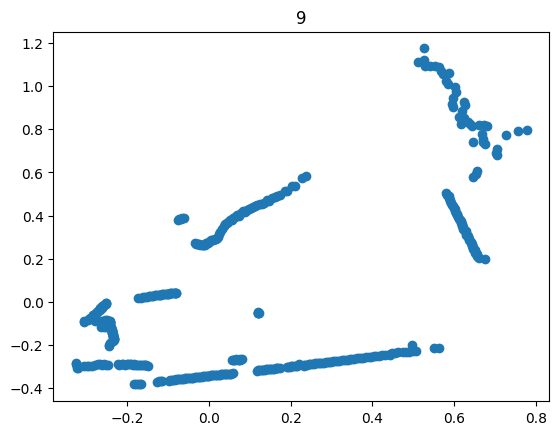

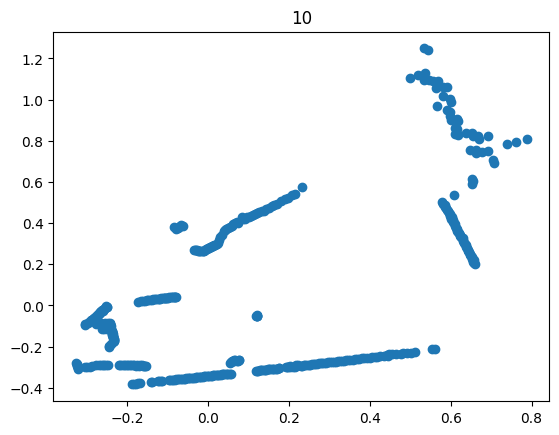

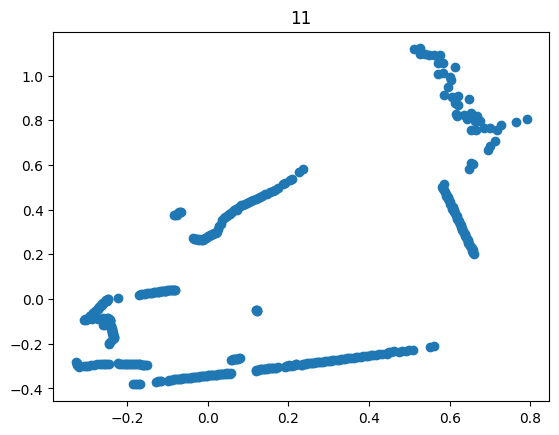

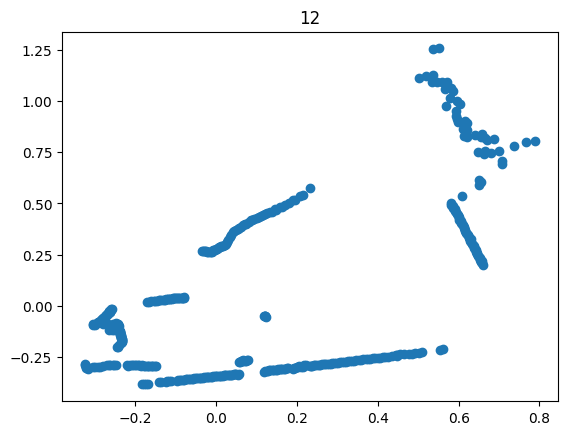

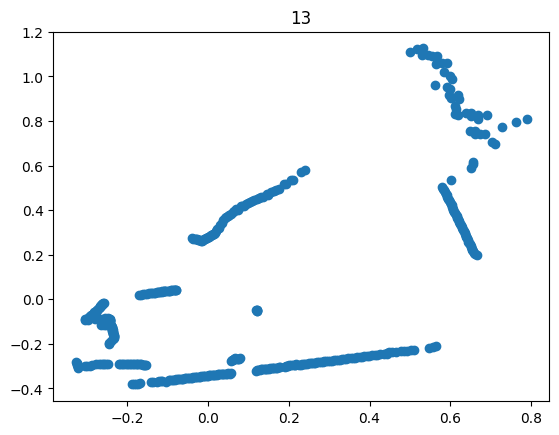

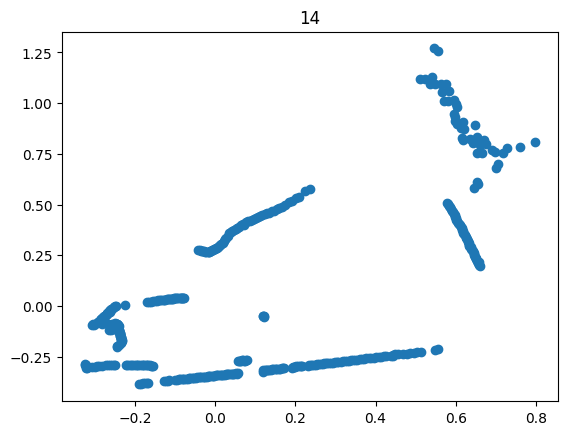

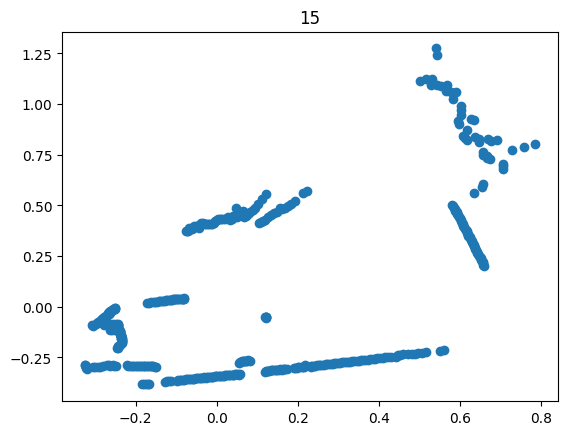

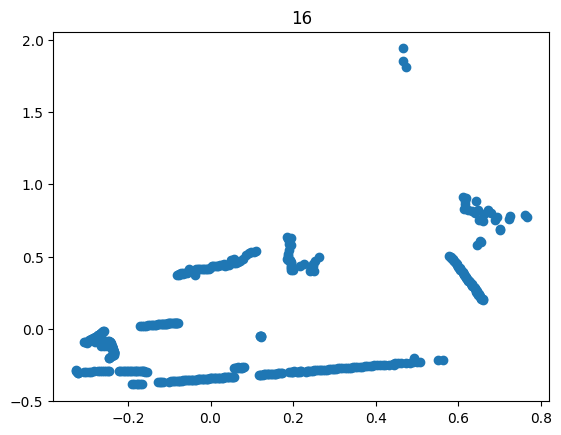

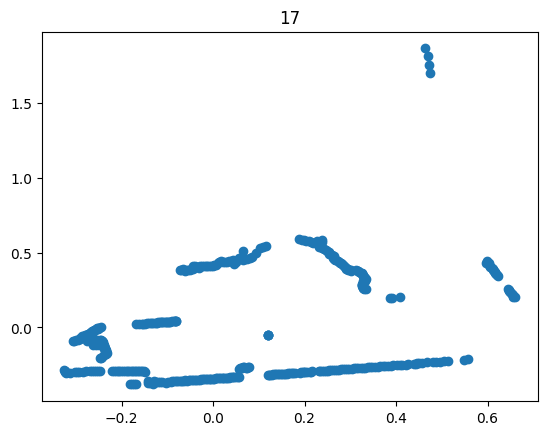

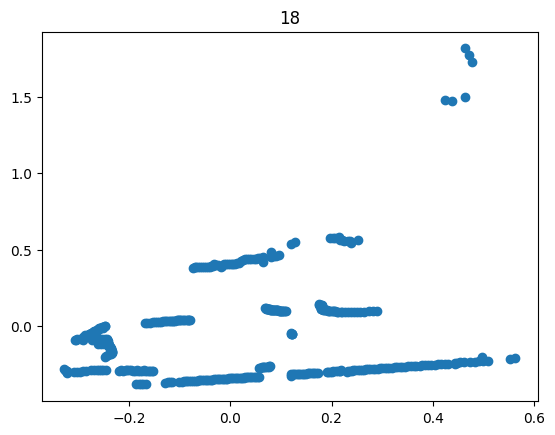

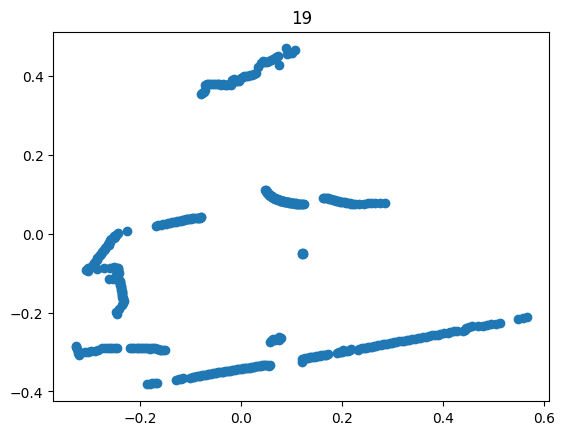

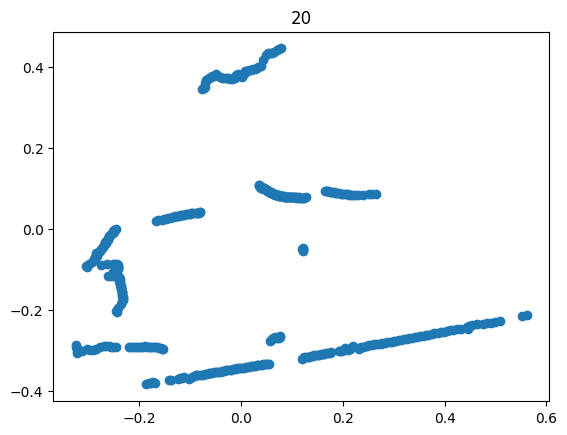

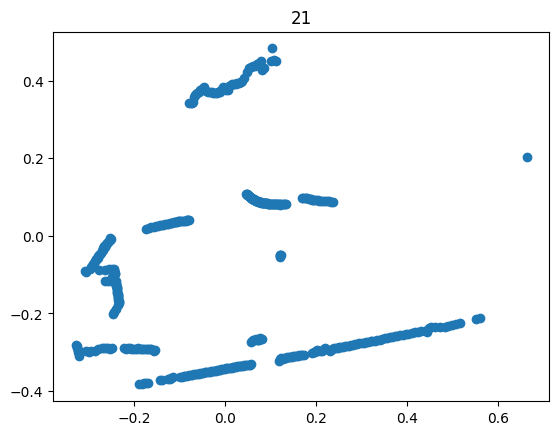

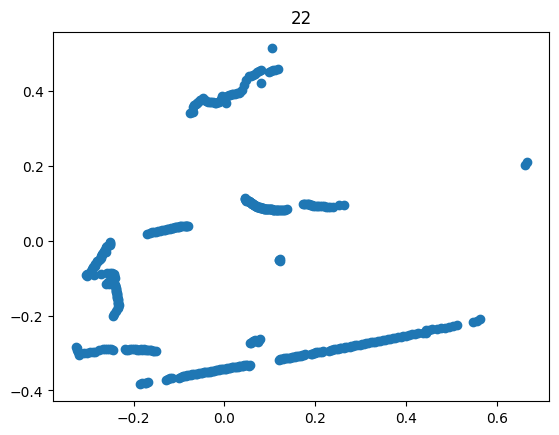

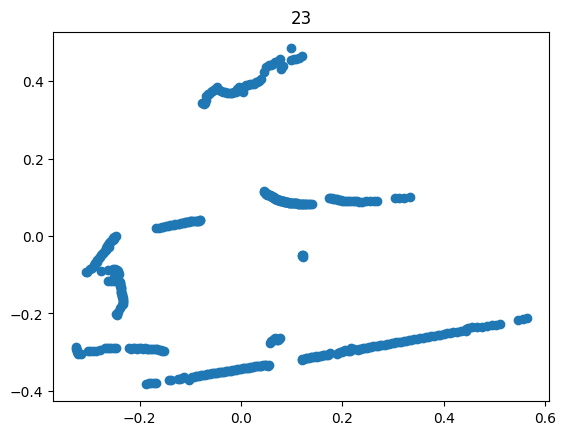

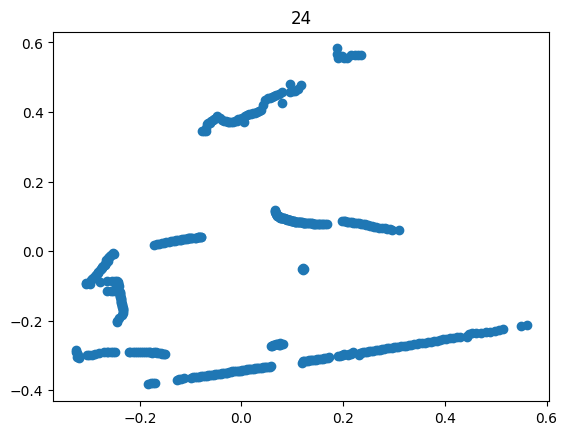

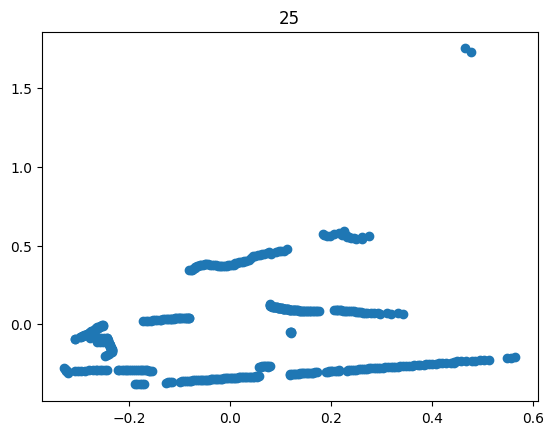

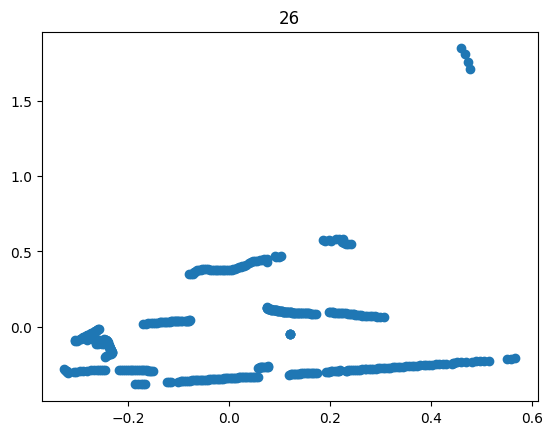

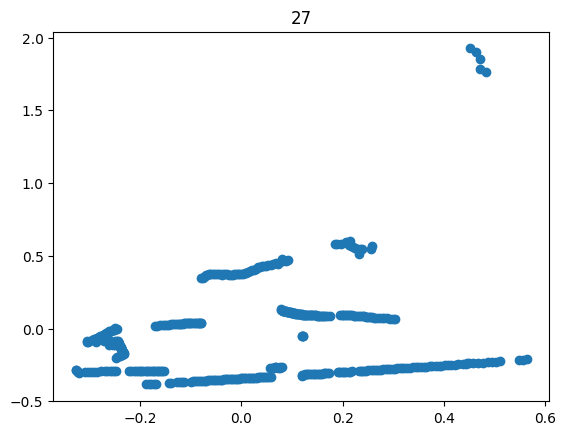

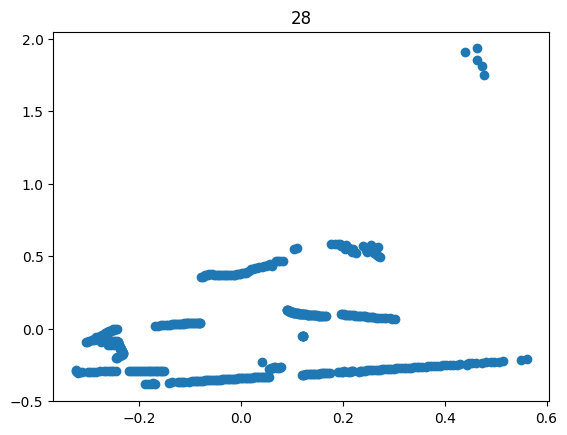

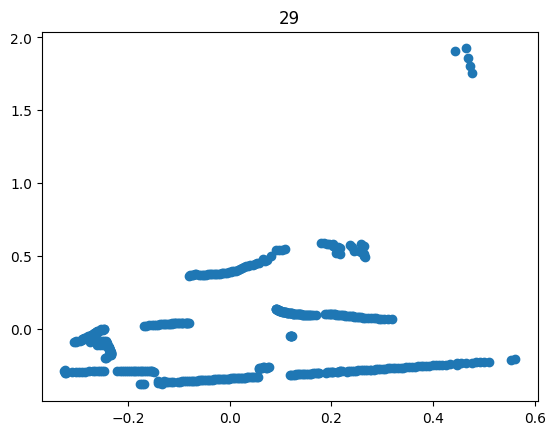

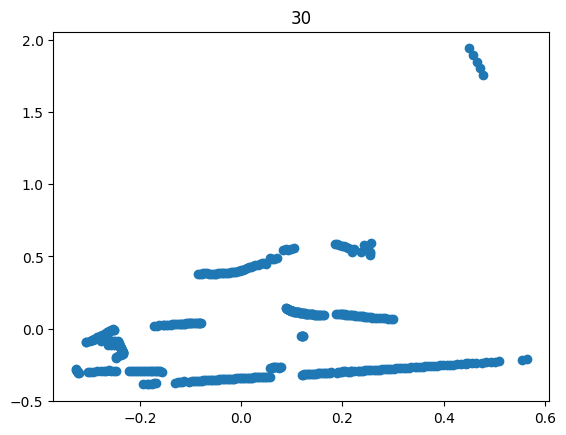

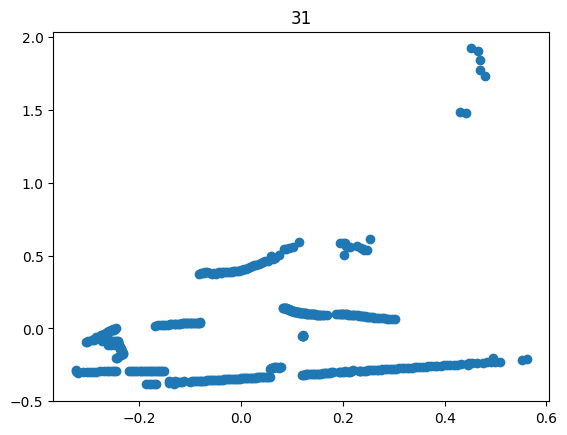

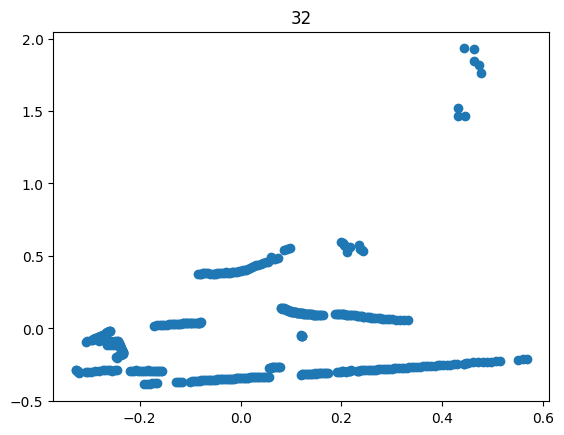

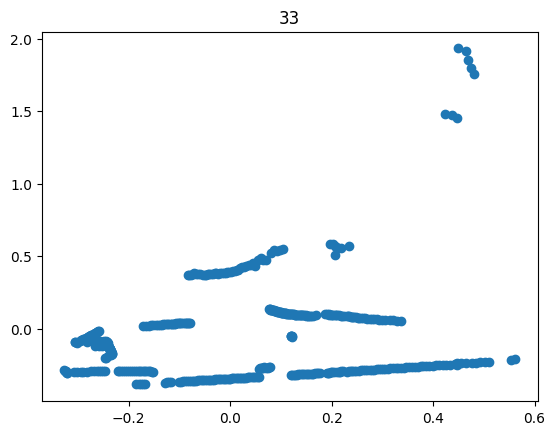

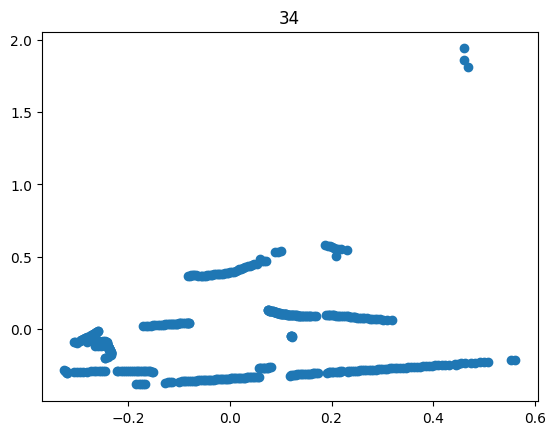

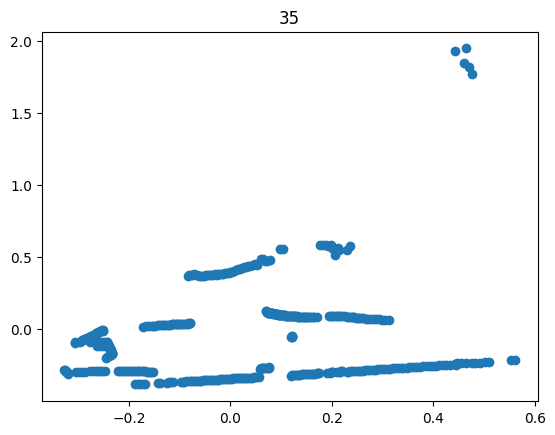

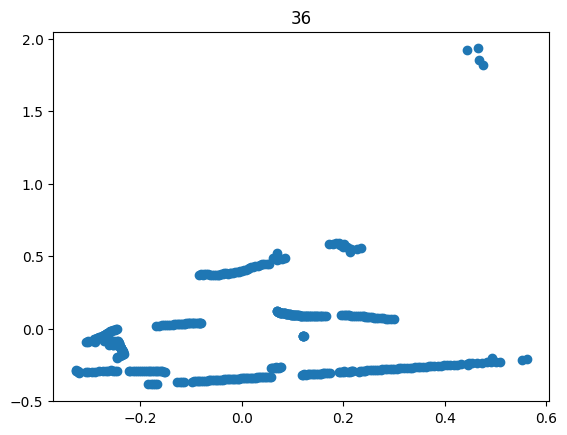

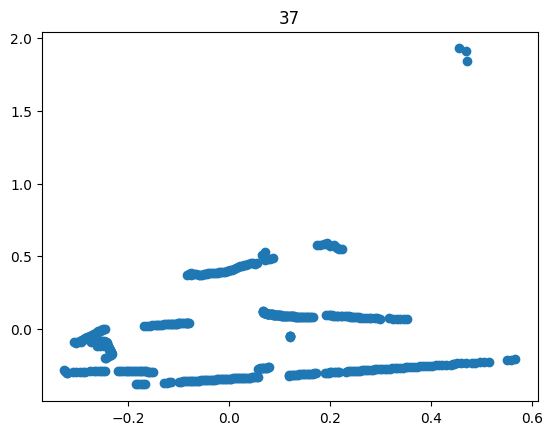

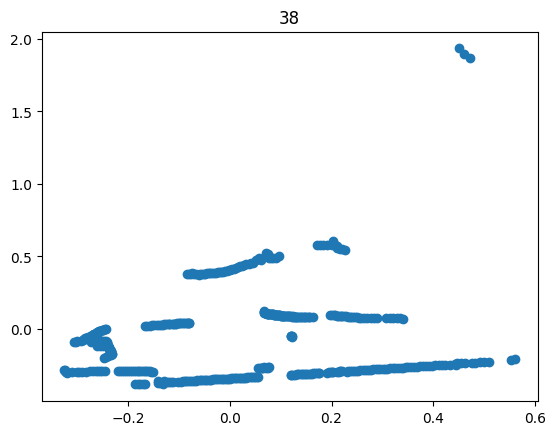

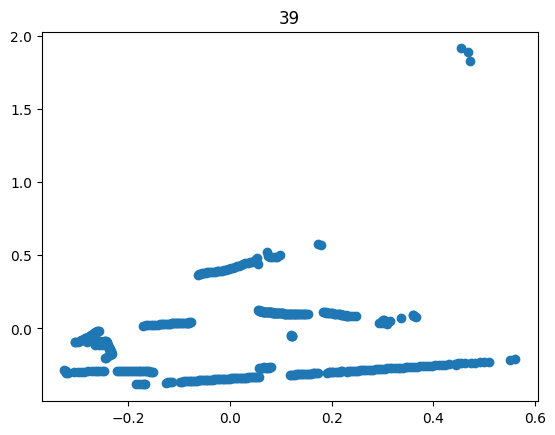

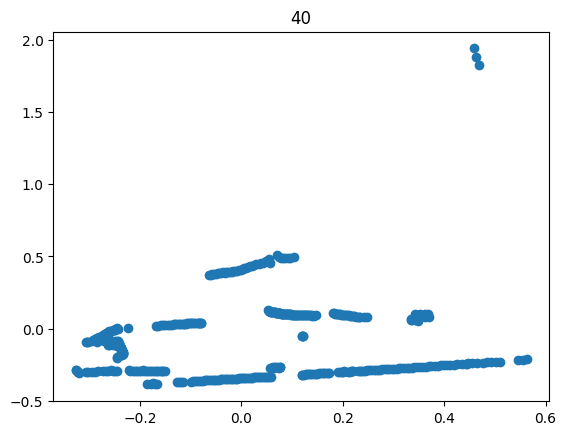

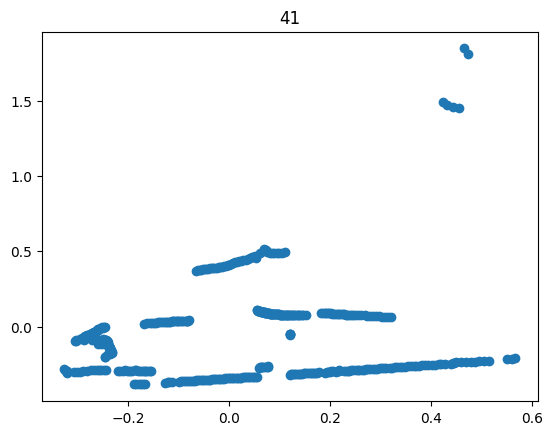

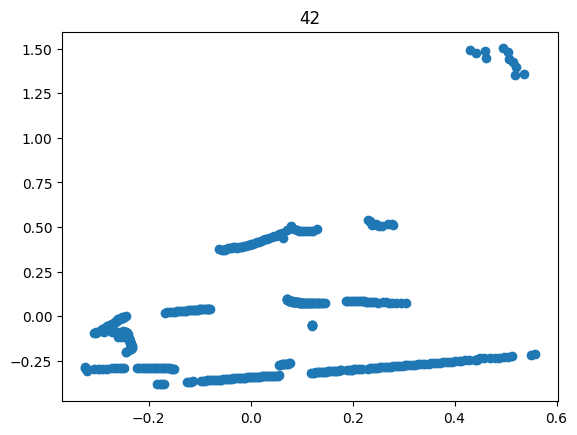

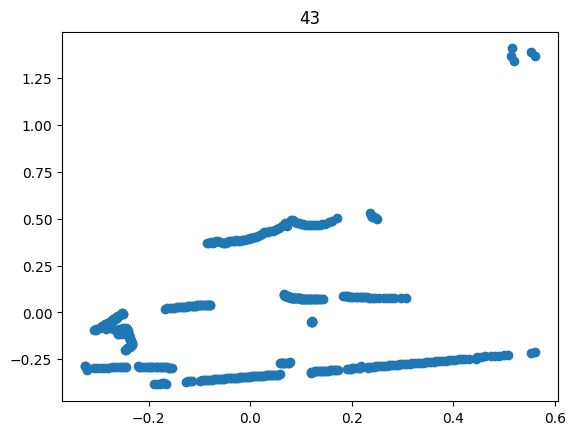

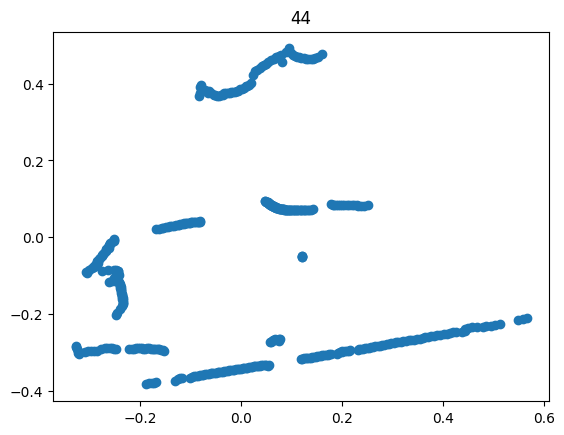

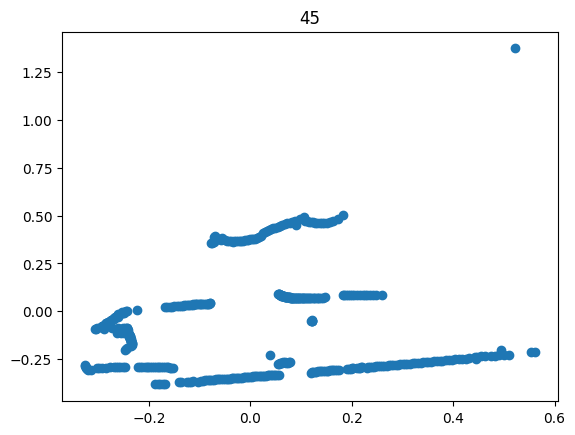

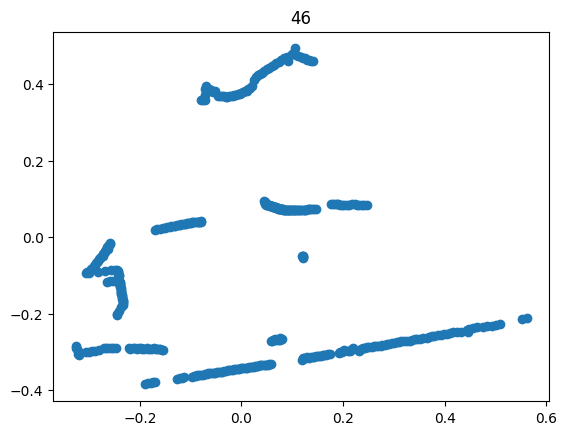

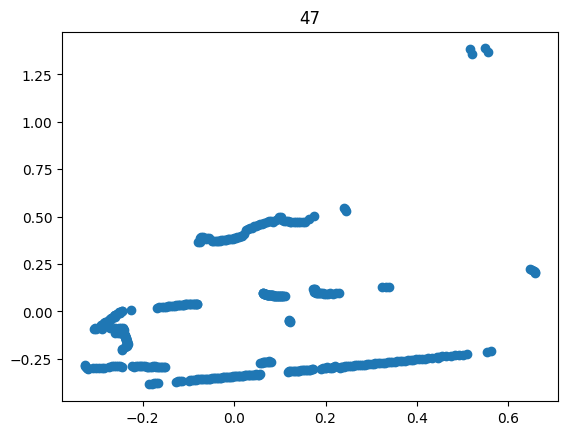

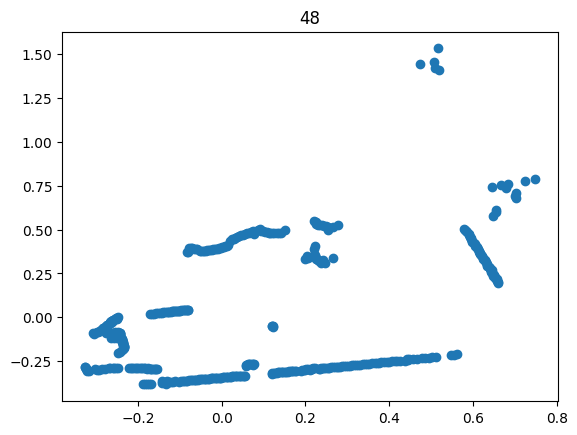

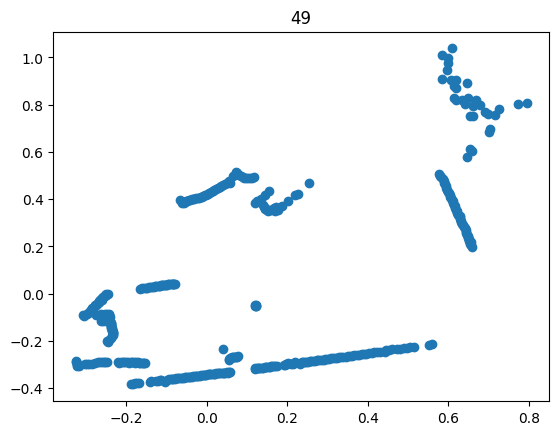

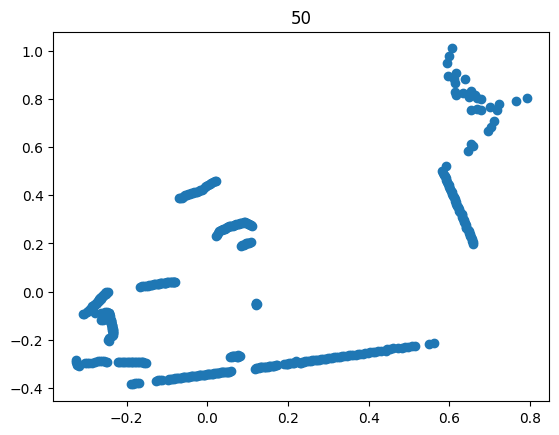

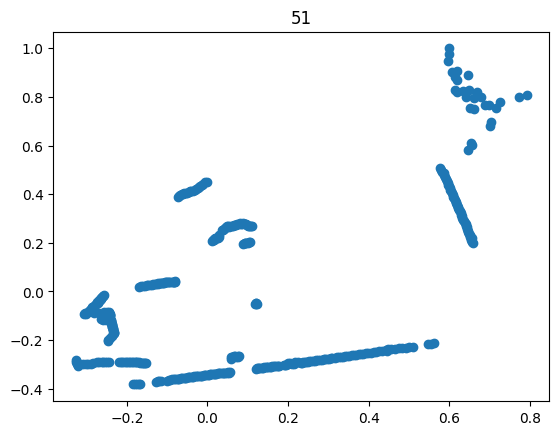

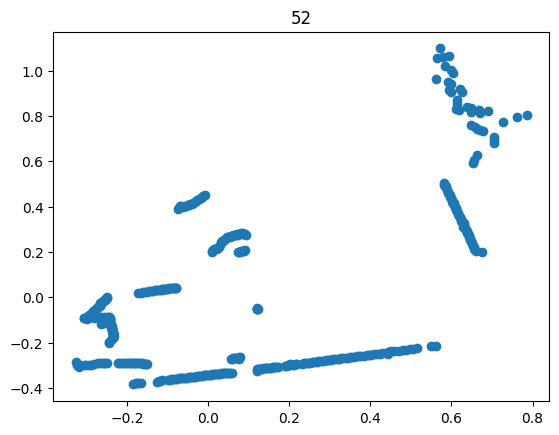

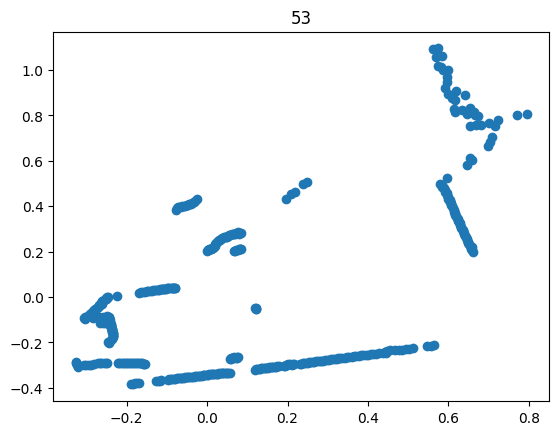

In [55]:
import matplotlib.pyplot as plt
import numpy as np
file = open('cleaned.txt', 'r')
j = 0
for line in file.readlines():
    stripped = line.replace('\n', ' ').replace('(', ' ').replace(')', ' ').replace('[', ' ').replace(']', ' ').replace(':', ',').replace(' ', '').split(',')[2:]
    x = []
    y = []
    for i in range(int(len(stripped)/2)):
        x.append(float(stripped[2 * i]))
        y.append(float(stripped[2 * i + 1]))
    plt.scatter(x, y)
    plt.title(j)
    plt.show()
    j += 1